In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from datetime import datetime
import os

In [5]:
# Set up paths
root_dir = Path('/Users/andreashill/Desktop/GitHub/TrackTrend')
source_db_path = root_dir / 'data' / 'spotify_tracks.db'
processed_csv_path = root_dir / 'data' / 'spotify_tracks_processed.csv'
vis_dir = root_dir / 'visualizations'

In [6]:
# Connect to the database and load data
conn = sqlite3.connect(source_db_path)
query = "SELECT * FROM tracks"
df = pd.read_sql_query(query, conn)
conn.close()
print(f"Loaded {len(df)} rows from source database.")

Loaded 300 rows from source database.


In [10]:
if df.empty:
    print("No data to process.")
    exit()

# Convert date to datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

In [12]:
# Process data
df['rank'] = pd.to_numeric(df['rank'], downcast='integer')
df['popularity'] = pd.to_numeric(df['popularity'], downcast='integer')
df['duration_minutes'] = df['duration_ms'] / 60000

In [14]:
# Normalize features
features_to_normalize = ['danceability', 'energy', 'loudness', 'speechiness', 
                         'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(df[features_to_normalize])
normalized_column_names = [f"{feature}_normalized" for feature in features_to_normalize]
df[normalized_column_names] = normalized_features

# Save processed data to CSV
df.to_csv(processed_csv_path, index=False)
print(f"Processed and saved {len(df)} entries to CSV.")

Processed and saved 300 entries to CSV.



Acousticness Sample:
     acousticness  acousticness_normalized
109       0.06780                 0.069068
228       0.00353                 0.002678
208       0.01560                 0.015146
265       0.03930                 0.039628
216       0.96800                 0.998967

Acousticness Summary:
       acousticness  acousticness_normalized
count    300.000000               300.000000
mean       0.179450                 0.184401
std        0.227333                 0.234834
min        0.000938                 0.000000
25%        0.023500                 0.023306
50%        0.085800                 0.087662
75%        0.246000                 0.253147
max        0.969000                 1.000000


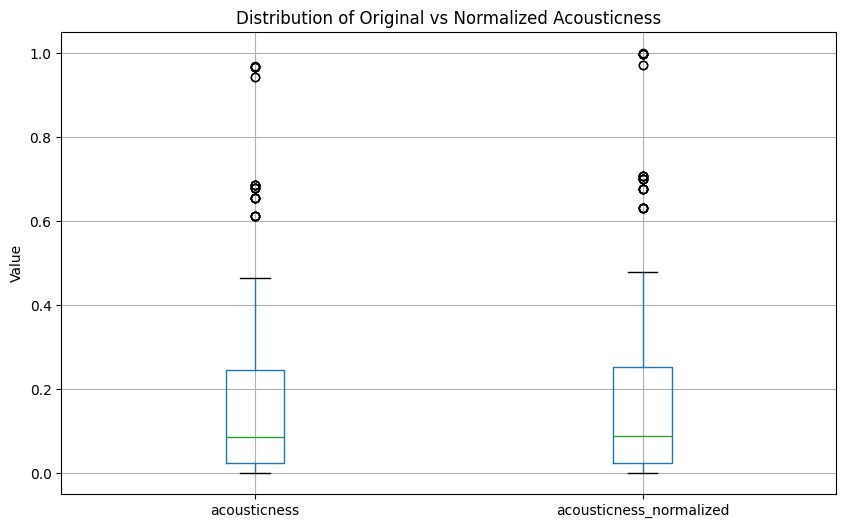

In [16]:
# Visualize original vs normalized acousticness
acoustic_features = ['acousticness', 'acousticness_normalized']
print("\nAcousticness Sample:")
print(df[acoustic_features].sample(5))

print("\nAcousticness Summary:")
print(df[acoustic_features].describe())

plt.figure(figsize=(10, 6))
df[acoustic_features].boxplot()
plt.title('Distribution of Original vs Normalized Acousticness')
plt.ylabel('Value')

# Save figure
plt.savefig(vis_dir / 'original_vs_norm_accoustic.png', dpi=300, bbox_inches='tight')

plt.show()

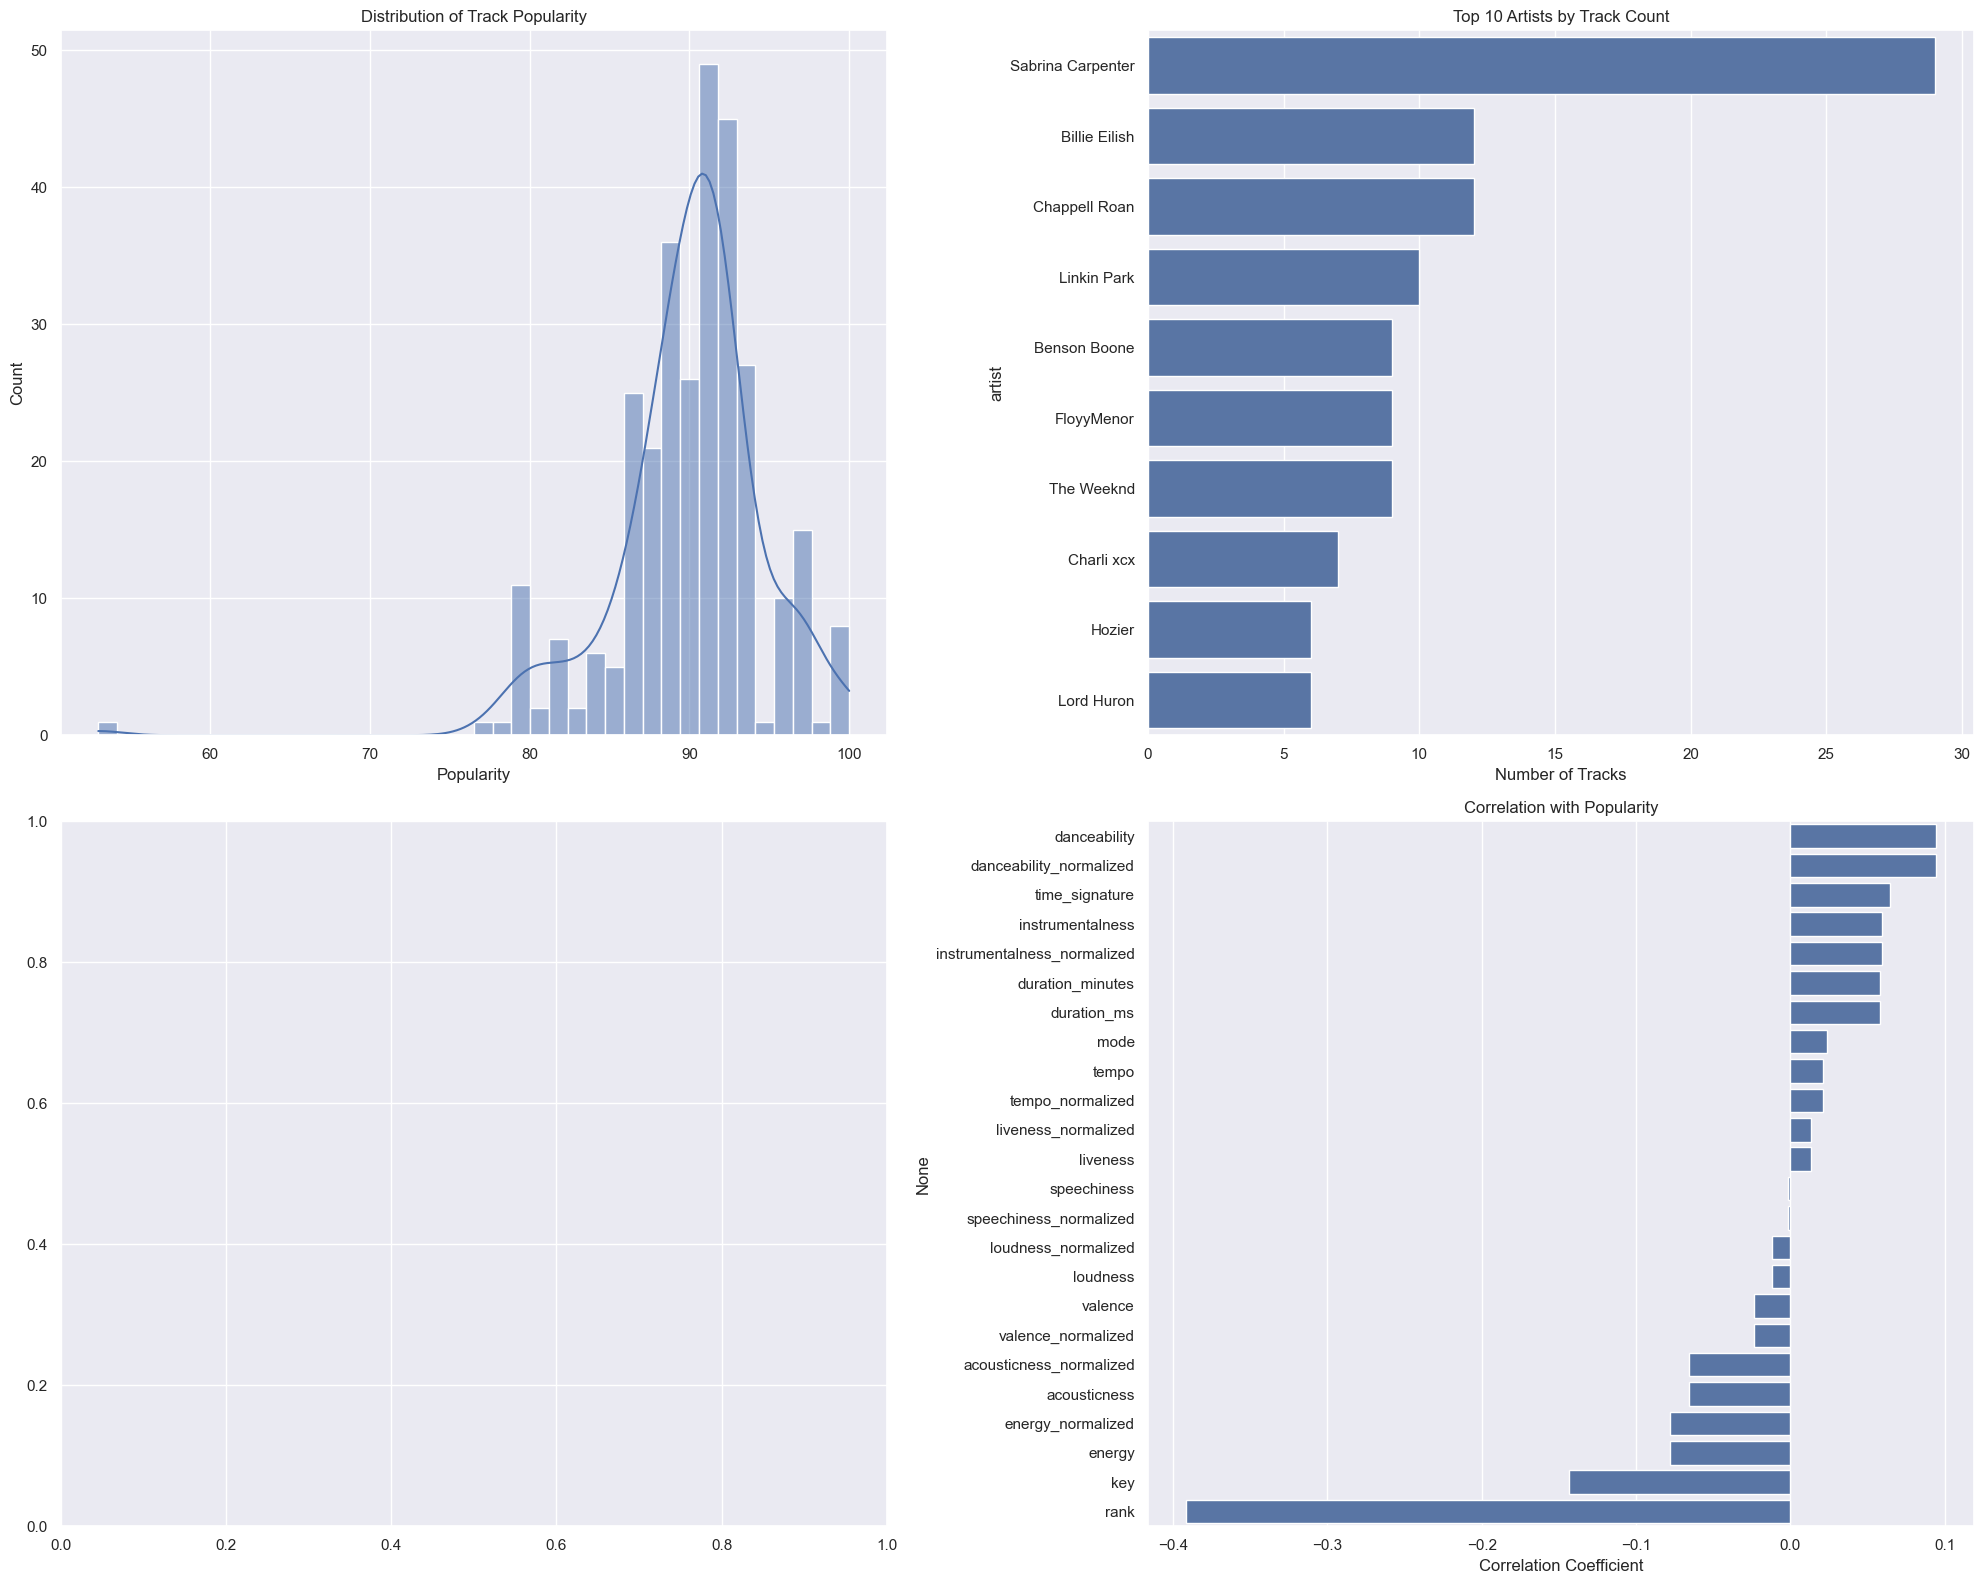

In [18]:
#set up plotting style 
sns.set_theme()

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Popularity distribution
sns.histplot(data=df, x='popularity', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Track Popularity')
axes[0, 0].set_xlabel('Popularity')

# 2. Top 10 artists by track count
top_artists = df['artist'].value_counts().head(10)
sns.barplot(x=top_artists.values, y=top_artists.index, ax=axes[0, 1])
axes[0, 1].set_title('Top 10 Artists by Track Count')
axes[0, 1].set_xlabel('Number of Tracks')

# 3. Correlation between popularity and other numeric features
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlations = df[numeric_cols].corr()['popularity'].sort_values(ascending=False)
sns.barplot(x=correlations.values[1:], y=correlations.index[1:], ax=axes[1, 1])
axes[1, 1].set_title('Correlation with Popularity')
axes[1, 1].set_xlabel('Correlation Coefficient')

# Save figure
plt.savefig(vis_dir / 'charts.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [20]:
# Select features and target
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo']
X = df[features]
y = df['rank']  # Assuming 'rank' is the chart position

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [30]:
# Make predictions
y_pred = rf_model.predict(X_test_scaled)

In [32]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 4.055848236485738
Root Mean Squared Error: 5.524179588139402


In [34]:
# Feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

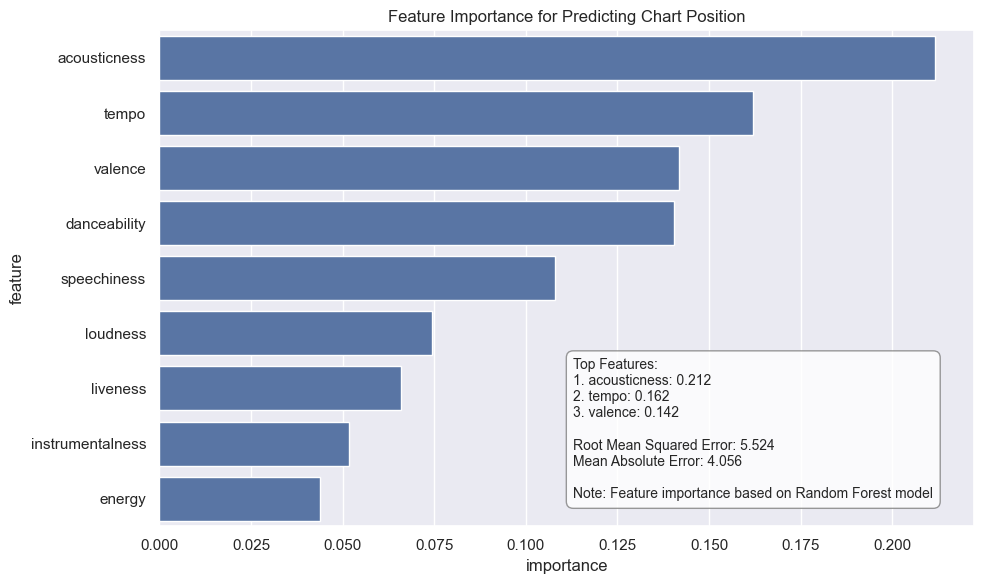

In [36]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Predicting Chart Position')

text_content = (
    'Top Features:\n'
    f"1. {feature_importance.iloc[0]['feature']}: {feature_importance.iloc[0]['importance']:.3f}\n"
    f"2. {feature_importance.iloc[1]['feature']}: {feature_importance.iloc[1]['importance']:.3f}\n"
    f"3. {feature_importance.iloc[2]['feature']}: {feature_importance.iloc[2]['importance']:.3f}\n\n"
    f"Root Mean Squared Error: {rmse:.3f}\n"
    f"Mean Absolute Error: {mae:.3f}\n\n"
    'Note: Feature importance based on Random Forest model'
)

plt.text(0.95, 0.05, text_content, 
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'),
         multialignment='left')


plt.tight_layout()

# Save figure
plt.savefig(vis_dir / 'feature_predicting_chart_position.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

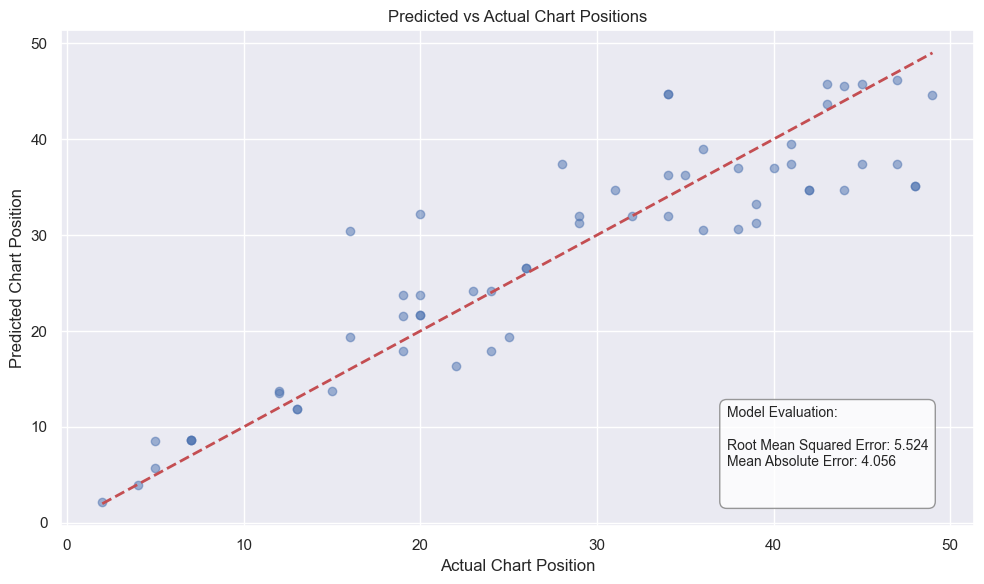

In [37]:
# Visualize predicted vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Chart Position')
plt.ylabel('Predicted Chart Position')
plt.title('Predicted vs Actual Chart Positions')
plt.tight_layout()

text_content = (
    'Model Evaluation:\n\n'
    f"Root Mean Squared Error: {rmse:.3f}\n"
    f"Mean Absolute Error: {mae:.3f}\n\n"
)

plt.text(0.95, 0.05, text_content, 
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'),
         multialignment='left')

# Save figure
plt.savefig(vis_dir / 'predict_vs_actual_chart.png', dpi=300, bbox_inches='tight')

plt.show()